# Investigating the frequency and battery charge

We start by importing libaries that should have been installed when installing the package

The `dynamic_containment` module is part of this package

In [1]:
import pandas as pd
from datetime import timedelta, date
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
from scipy import special
import openturns as ot
from scipy.optimize import least_squares
from scipy.optimize import minimize
import warnings
from scipy.interpolate import interp1d
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn, norm
from scipy.signal import savgol_filter

from dynamic_containment import utils

plt.rcParams['text.usetex'] = False

## Create the battery charge model

We have set up a function within `dynamic_containment` to calculate the change in charge associated with each frequency. This is the opposite of the service power and includes charge efficiency.

Text(0, 0.5, 'Charge %')

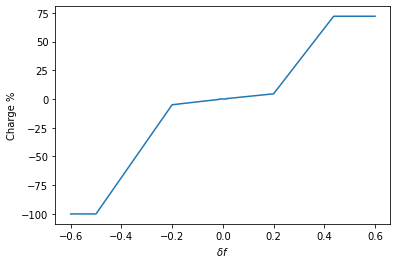

In [2]:
df = np.linspace(-0.6, 0.6, num=1000)

service_power = 5
max_discharge_rate=5
max_charge_rate=4
charge_efficiency=0.9
max_cap=4

plt.plot(df, [100*utils.battery_power(dfi, service_power,  max_discharge_rate, max_charge_rate, charge_efficiency, max_cap) for dfi in df])
plt.xlabel("$\delta f$")
plt.ylabel("Charge %")

## Read in the data

Here we read in the data and make some small changes to column namnes etc

In [3]:
input_freq_table = utils.read_and_clean()

Let's look a the frequency. Throughout the notebook I used $\delta f=$ frequency - 50

<AxesSubplot:xlabel='date'>

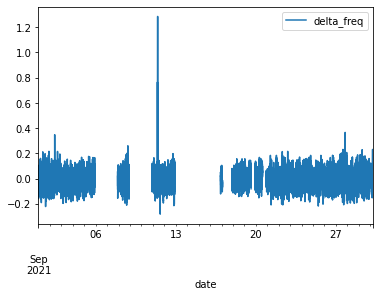

In [4]:
input_freq_table.plot("date", "delta_freq")

There maybe some time dependence. We will extract a continous time series just in case.

In [5]:
freq_table = utils.create_continuous_timeseries(input_freq_table)

I'll just check it is continous

In [6]:
freq_table["time"] = freq_table["date"].dt.strftime("%H%M%S")

freq_table["seconds"] = (
    freq_table["time"].str[:2].astype(int)*3600
    + freq_table["time"].str[2:4].astype(int)*60
    + freq_table["time"].str[4:6].astype(int)
)

freq_table['diff_time'] = freq_table['seconds'] - freq_table['seconds'].shift(1)

freq_table.query("diff_time!=1").max()

date          2021-09-30 00:00:00
freq                       50.067
delta_freq                  0.067
time                       000000
seconds                         0
diff_time                -86399.0
dtype: object

So the time difference is a multiple of 24 hrs, as intended

I just want to see what impact the outliers have on the standard deviation

In [7]:
freq_disp = freq_table.delta_freq.std()

In [8]:
freq_table[np.abs(freq_table.delta_freq) < 5 * freq_disp]["delta_freq"].std()

0.06034411257283988

In [9]:
freq_disp

0.060360594216720714

This doesn't have a big impact on the dispersion. 

Let's remove the outliers

In [10]:
mask = np.abs(freq_table.delta_freq) < 5 * freq_disp

In [11]:
freq_table = freq_table[mask]

Let's look at a histogram of the frequencies

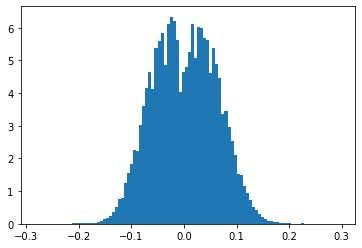

In [12]:
hist = plt.hist(freq_table.delta_freq, bins=100, density=True)

It's looks pretty symmetric, but it seems to have two peaks. Let's see how well a Normal distribution fits

In [13]:
bin_cents = 0.5*(hist[1][1:] + hist[1][:-1])

In [14]:
f = least_squares(utils.hist_fit_gauss, x0 = [0.0, 0.04], args=(bin_cents, hist[0]))

In [15]:
gauss = norm.pdf(bin_cents, f.x[0], f.x[1])
gauss = gauss / np.trapz(gauss, bin_cents)

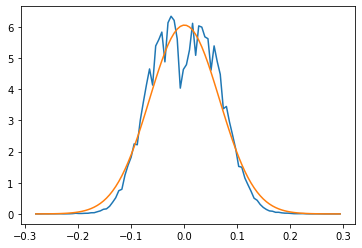

In [16]:
plt.plot(bin_cents, hist[0])
plt.plot(bin_cents, gauss)

Not great, but we will start by assuming it is Normal, but come back to this.

We can calculate the the charge, assuming we have a full battery to begin with, for simplicity, ignoring going battery capacity for now.

In [17]:
freq_table = utils.add_charge_info(freq_table, service_power)

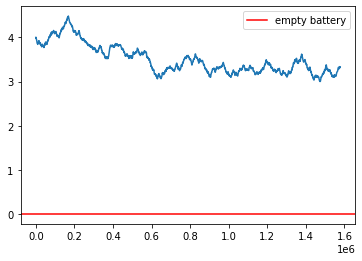

In [18]:
plt.plot(max_cap + freq_table.culm_charge)
plt.axhline(0.0, color='red', label="empty battery")
plt.legend()

# Creating mock data for better stats

Now let's try and generate more data using Gaussian simulations. I will start by trying using the spectral density of $\delta f$. To do this, I am using the `openturns` package

In [19]:
process = utils.simulate_delta_f(freq_table)

In [20]:
# draw a sample
sample = process.getSample(1)

WRN - Warning! The cache for cholesky factors is full. Expect a big performance penalty. Increase the cache size using the ResourceMap key "SpectralGaussianProcess-CholeskyCacheSize" if you have enough memory.


In [21]:
vals = [sample[0][i][0] for i in range(len(sample[0]))]

There is a scaling problem that I need to look into, but we can sidestep this for now by scaling the variance.

In [22]:
vals = np.array(vals) * freq_table.delta_freq.std() / np.std(vals)

Now we have the correct standard deviation.

In [23]:
freq_table.delta_freq.std()

0.06034411257283988

In [24]:
vals.std()

0.060344112572839864

We can process the simulated data now

In [25]:
df_sim = pd.DataFrame()
df_sim['date'] = range(len(vals))
df_sim['delta_freq'] = vals

In [26]:
df_sim = utils.add_charge_info(df_sim, service_power)

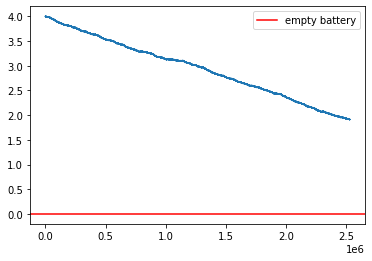

In [27]:
plt.plot(df_sim.date, max_cap + df_sim.culm_charge)
plt.axhline(0.0, color='red', label="empty battery")
plt.legend()

Let's just look at the behaviour of the frequencies at smaller scales. Say, 1 hour

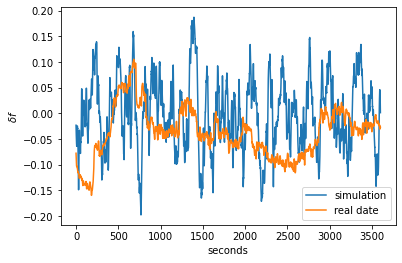

In [28]:
plt.plot(df_sim.iloc[:3600]["date"], df_sim.iloc[:3600]["delta_freq"], label="simulation")
plt.plot(df_sim.iloc[:3600]["date"], freq_table.iloc[:3600]["delta_freq"], label="real date")
plt.xlabel("seconds")
plt.ylabel("$\delta f$")
plt.legend()

Interesting, it doesn't look right. It would be nice to understand why, but for now, let's see how we get on using a two-point correlation function instead. We sample the covariance and interpolate for speed.

Note, we alo compare the uncut table, out of interest, as this may protentially provide a better covariance

In [29]:
max_time_cov = 36001
time_step_cov = 60

real_space_cov = utils.temporal_covariance(freq_table, max_sep=max_time_cov, step=time_step_cov )

  0%|          | 0/601 [00:00<?, ?it/s]

In [30]:
real_space_cov_uncut = utils.temporal_covariance(input_freq_table, max_sep=max_time_cov, step=time_step_cov )

  0%|          | 0/601 [00:00<?, ?it/s]

Text(0, 0.5, 'Covariance')

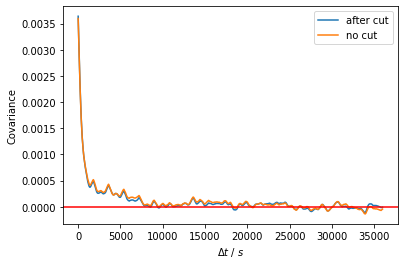

In [31]:
plt.plot(real_space_cov.keys(), real_space_cov.values(), label="after cut")
plt.plot(real_space_cov_uncut.keys(), real_space_cov_uncut.values(), label="no cut")
plt.legend()
plt.axhline(0.0, color='red')
plt.xlabel("$\Delta t$ / $s$")
plt.ylabel("Covariance")

The cut data appears to have slightly less correlation in general. This maybe due to bolting chunks together. For these tests, we use the cut data to compare the battery charge on continuous data and assess the method, but when performing our main analysis, we do not cut to have a better level of covariance in our uncertainty estimates.

Now we can generate mock Gaussian sims using this covariance.

To make the simulations faster, I have created samples at time steps of 5 mins. This will increase small-scale correlations, but I think it is the large-scale correlations that are potentially the most problematic. I also produce the simulations in 3-hour blocks. Looking at the real data above, one hour seems to capture the big fluctations in frequency, so 3 hours should be safe.

First though, I create 10x resolution simulations (so 6 seconds) as a test

In [32]:
# This is the number of realisations. I have tested at higher values, but takes longer to run
nreals = 100 # The higher the better...
time_step = 6
block_length = 36000 # 10 hrs

num_blocks = np.ceil(len(freq_table.delta_freq) / block_length)

num_samples = [nreals, int(num_blocks)]

samples = utils.simulate_grf_using_cov(real_space_cov, max_time=block_length, time_step=time_step, num_samples=num_samples)

In [33]:
new_samples_1 = [s.flatten()[:int(np.ceil(len(freq_table)/time_step))] for s in samples]

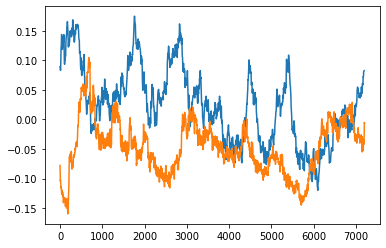

In [34]:
plt.plot(np.arange(int(7200/time_step)) * time_step, new_samples_1[0][:int(7200/time_step)])
plt.plot(
    freq_table.delta_freq.iloc[:7200]
)

This looks a lot better!

One thing we can do now is look at the dispersion of the mean $\delta f$, and use this information to see if there is evidence of a bias in our real data

I also create my lower resolution simulations to compare the recovered noise estimate

In [35]:
# first makes sure I generate enough data (18000s = 5hrs)

num_blocks = np.ceil(len(freq_table.delta_freq) / block_length)

time_step = 600
num_samples = [nreals, int(num_blocks)]

samples = utils.simulate_grf_using_cov(real_space_cov, max_time=block_length, time_step=time_step, num_samples=num_samples)

In [36]:
new_samples = [s.flatten()[:int(np.ceil(len(freq_table)/time_step))] for s in samples]

In [37]:
means = np.mean(new_samples, axis=1)
means_comp = np.mean(new_samples_1, axis=1)

In [38]:
print(f"Standard deviation on the mean with 10x resolution is {means_comp.std()}")

Standard deviation on the mean with 10x resolution is 0.0019463839909809987


In [39]:
print(f"Standard deviation on the mean is {means.std()}")

Standard deviation on the mean is 0.0019970896551237045


Since there is more information in the higher case resolution case, we would expect this dispersion to be a little lower, since we have more frequencies. However, as these are highly correlated, this does not have a big impact. It appears that we are not losing to much information by downsampling, since on scales below 600 seconds. We will continue using 600 second samples.

As a further comparison, we can calculate the error on the mean frequency using the covariance matrix directly, this also appears to agree:

In [40]:
cov_matrix = utils.square_cov(real_space_cov, max_time=block_length, time_step=time_step)

np.sqrt(np.sum(cov_matrix) / num_blocks)/np.shape(cov_matrix)[0]

0.002172568102266327

Now we need to look at the impact of creating the simulations in blocks. This is done to speed things up, but around the points where two blocks are bolted together, we are losing the correlations between points in the two blocks.

In [41]:
max_seps = np.arange(3000) * 60 + 60

time_step = 600
real_space_cov = utils.temporal_covariance(freq_table, max_sep=block_length, step=time_step)
cov_matrix = utils.square_cov(real_space_cov, max_time=max_seps[-1], time_step=time_step)

  0%|          | 0/60 [00:00<?, ?it/s]

In [42]:
test = []

for i in max_seps:
    
    num_blocks = np.ceil(len(freq_table.delta_freq) / (i))
    test.append(
        np.sqrt(np.sum(cov_matrix[:int(i/time_step), :int(i/time_step)]) * num_blocks) / num_blocks / int(i/time_step+1)
    )



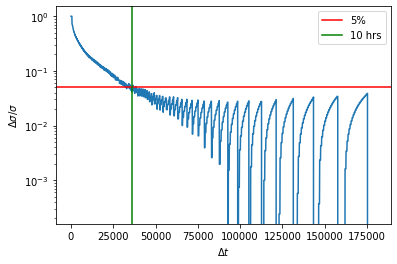

In [43]:
frac_err = (test[-1]-test)/test[-1]

#kernel_size = 1000
#kernel = np.ones(kernel_size) / kernel_size
#data_convolved = np.convolve(frac_err, kernel, mode='same')

plt.semilogy(max_seps, frac_err)
#plt.plot(max_seps, data_convolved)
plt.axhline(0.05, color='red', label="5%")
plt.axvline(36000, color='green', label="10 hrs")
plt.xlabel("$\Delta t$")
plt.ylabel("$\Delta \sigma/\sigma$")
plt.legend()

Here we see that the bias caused by using blocks in our simulation should by below 5% when using blocks greater than 10 hrs

In [44]:
print(f"The mean of the real (uncut) data is {np.mean(input_freq_table.delta_freq)}")

The mean of the real (uncut) data is 0.001010777745241588


So the real data sees no evidence of a bias in the frequency.

Below, we just check that we are not expecting to lose much information with our choice of timestep, focusing on the variance in the mean frequency

In [45]:
std_vs_time_step = []

time_step_arr = np.linspace(10,1200, num=100)

for t in time_step_arr:
    
    cov_matrix = utils.square_cov(real_space_cov, max_time=block_length, time_step=t)

    std_vs_time_step.append(np.sqrt(np.sum(cov_matrix) / num_blocks)/np.shape(cov_matrix)[0])
    

Text(0, 0.5, '$\\Delta \\sigma / \\sigma$')

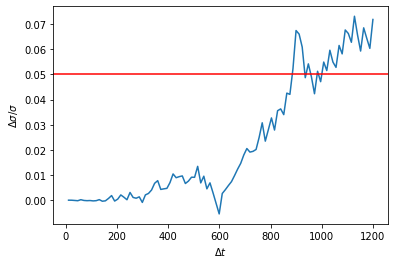

In [46]:
plt.plot(time_step_arr, (std_vs_time_step-std_vs_time_step[0])/std_vs_time_step[0])
plt.axhline(0.05, color='red')
plt.xlabel('$\Delta t$')
plt.ylabel('$\Delta \sigma / \sigma$')

The below around $\Delta t=100$, the fractional difference looks fairly constant, so there is nothing to gain from sampling below this. The fractional difference then hits five percent at around $\Delta t=800$. We feel confident therefore, that our choice of $\Delta t=600$ is sufficient for investigating the noice properties of the charge.

The bias is also opposite in sign to the above bias caused by using blocks, so we do not expect these bias to compound each other.

It should be noted, that these approximations are made soley to speed up the process, but they could easily be relaxed for a more accurate test.

Let's now process all of our realisations to give us a suite of mock charge losses.

This takes a few mins!

In [47]:
reals = {}

count = 0

for s in tqdm(new_samples):
    
    df = pd.DataFrame()
    df["date"] = np.arange(len(s)) * time_step
    df["delta_freq"] = s
    df = utils.add_charge_info(df, service_power, delta_time=time_step)
    
    reals[count] = df
    
    count+=1
    

  0%|          | 0/100 [00:00<?, ?it/s]

One thing we should do is check the covariance of the mocks...

In [48]:
sample_covariance = utils.temporal_covariance(reals[0], max_sep=int(block_length/time_step), step=1)

  0%|          | 0/60 [00:00<?, ?it/s]

Text(0, 0.5, 'Covariance')

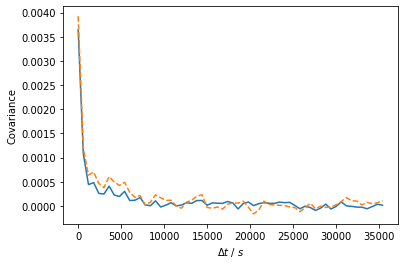

In [49]:
sample_cov_points = [i * time_step for i in sample_covariance.keys()]

plt.plot(real_space_cov.keys(), real_space_cov.values())
plt.plot(sample_cov_points, sample_covariance.values(), '--')
plt.xlabel("$\Delta t$ / $s$")
plt.ylabel("Covariance")

OK, it looks great. We'll calculate some basic summary stats of the sims

In [50]:
df_mean = reals[0].copy()
df_mean['culm_charge'] = 0.0
df_mean['culm_charge_sq'] = 0.0

for s in reals:
    
    df_mean['culm_charge'] += reals[s]['culm_charge']
    df_mean['culm_charge_sq'] += reals[s]['culm_charge']**2.0

In [51]:
df_mean['culm_charge'] = df_mean['culm_charge'] / len(reals)

In [52]:
df_mean['var_charge'] = (
    df_mean['culm_charge_sq'] / (len(reals) - 1)
    - df_mean['culm_charge']**2.0 * len(reals) / (len(reals) - 1)
)

In [53]:
df_mean['std_charge'] = np.sqrt(df_mean['var_charge'])

As a comparison, I will also make some pure noise simulations.

In [54]:
gauss_noise = np.random.normal(0.0, freq_table['delta_freq'].std(), size=len(freq_table))

In [55]:
df_white_noise = pd.DataFrame()
df_white_noise['date'] = range(len(freq_table))
df_white_noise['delta_freq'] = gauss_noise

In [56]:
df_white_noise = utils.add_charge_info(df_white_noise, service_power)

Now let's plot the lot! Including a single simulated realisation

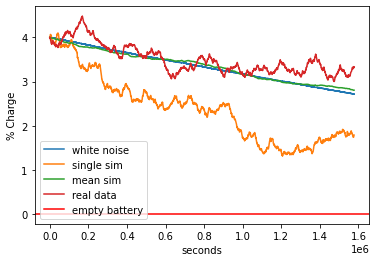

In [57]:
plt.plot(df_white_noise.date, max_cap + df_white_noise.culm_charge, label="white noise")
plt.plot(reals[0].date, max_cap + reals[3].culm_charge, label="single sim")
plt.plot(df_mean.date, max_cap + df_mean.culm_charge, label="mean sim")
plt.plot(df_white_noise.date, max_cap + freq_table.culm_charge, label="real data")
plt.axhline(0.0, color='red', label="empty battery")
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

This looks good! Be aware, the the single realisations fluctuate! And that includes the real data!

## Calculating the change in charge

Now let's have some fun. Assuming Gaussian distributed white noise data, we can calculate the average rate of change of charge in the battery.

In [58]:
c = utils.calc_gaussian_slope(freq_table.delta_freq.std(), service_power)

In [59]:
theory_charge = c * np.arange(len(df_white_noise))

In [60]:
sample_points = np.linspace(0, len(df_white_noise)-1, num=50)
sample_points = [int(np.round(sample_points[i])) for i in range(len(sample_points))]

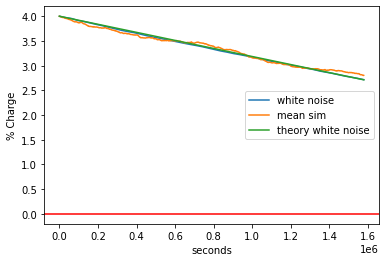

In [61]:
plt.plot(
    df_white_noise.iloc[sample_points].date,
    max_cap + df_white_noise.iloc[sample_points].culm_charge,
    label="white noise"
)
plt.plot(
    df_mean.date,
    max_cap + df_mean.culm_charge,
    label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    max_cap + theory_charge[sample_points],
    label="theory white noise"
)
plt.axhline(0.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

Great, now we know what the averege rate of change of charge is, assuming white noise data

In [62]:
print(f"It is dC/dt = {c*3600} MW")

It is dC/dt = -0.002934697598938956 MW


We can also do the same using a histogram of the real data

In [63]:
c_hist = utils.calc_data_slope(freq_table.dropna(), service_power, bins=34)

In [64]:
theory_charge_hist = c_hist * np.arange(len(df_white_noise))

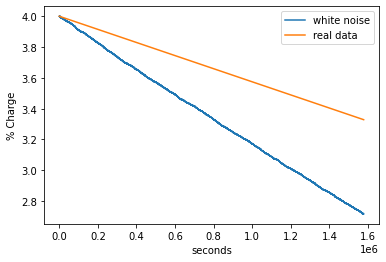

In [65]:
plt.plot(df_white_noise.date, max_cap + df_white_noise.culm_charge, label="white noise")
plt.plot(df_white_noise.date, max_cap + theory_charge_hist, label="real data")
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

This doesn't match the simulation, but is very susceptible to the bin size. Looking back, we had the frequency histogram

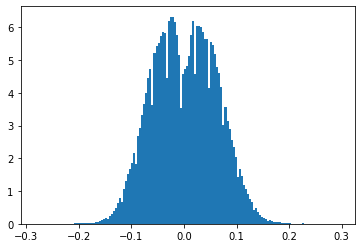

In [66]:
hist = plt.hist(freq_table.delta_freq, bins=150, density=True)

Which is double Peaked. This double Peak may cause an issue, since this pushes frequecies outside the deadband. Let's fit a double Normal distribution and see what happens. We can use this to calculate $dC / dt$ without worrying too much about binned finite data

In [67]:
bin_cents = 0.5*(hist[1][1:] + hist[1][:-1])

In [68]:
f = least_squares(utils.hist_fit_2gauss, x0 = [0.04, 0.04], args=(bin_cents, hist[0]))

In [69]:
gauss1 = norm.pdf(bin_cents, -f.x[0], f.x[1])
gauss2 = norm.pdf(bin_cents, f.x[0], f.x[1])

In [70]:
double_gauss = np.where(bin_cents<0, gauss1, gauss2)
double_gauss = double_gauss / np.trapz(double_gauss, bin_cents)

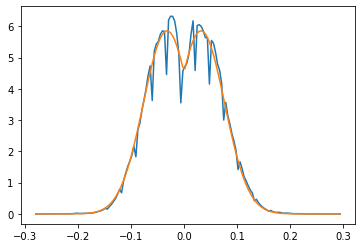

In [71]:
plt.plot(bin_cents, hist[0])
plt.plot(bin_cents, double_gauss)

That looks a bit better than a single Normal distribution. Let's try simulating it

In [72]:
samples = utils.generate_sample_df(double_gauss, bin_cents, num_samps=len(freq_table))

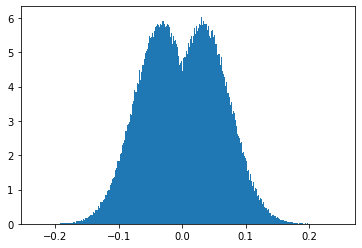

In [73]:
hist_samp = plt.hist(samples, density=True, bins=1000)

In [74]:
samples.std()

0.05997898274549288

Almost feels like a stroke of luck, but we appear to have a good match for the disperion!

In [75]:
sample_df = pd.DataFrame()
sample_df["date"] = range(len(samples))
sample_df["delta_freq"] = samples

In [76]:
sample_df = utils.add_charge_info(sample_df, service_power)

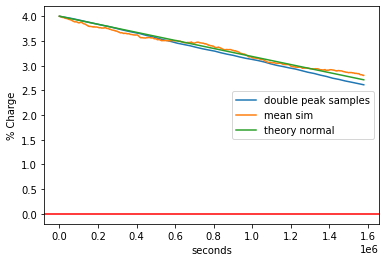

In [77]:
plt.plot(
    sample_df.iloc[sample_points].date,
    max_cap + sample_df.iloc[sample_points].culm_charge, label='double peak samples'
)
plt.plot(
    df_mean.date,
    max_cap + df_mean.culm_charge, label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    max_cap + theory_charge[sample_points], label="theory normal"
)
plt.axhline(0.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

In [78]:
fitted_c = utils.calc_fitted_slope(double_gauss, bin_cents, service_power)

In [79]:
theory_charge_hist = fitted_c * np.arange(len(df_white_noise))

In [80]:
time_step

600

In [81]:
sample_points_down = [int(s/time_step) for s in sample_points]

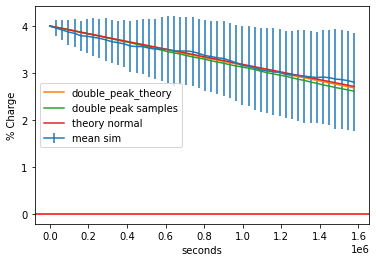

In [82]:
plt.errorbar(
    df_mean.iloc[sample_points_down].date,
    max_cap + df_mean.iloc[sample_points_down].culm_charge,
    df_mean.iloc[sample_points_down].std_charge,
    label="mean sim"
)
plt.plot(
    df_white_noise.iloc[sample_points].date,
    max_cap + theory_charge_hist[sample_points],
    label='double_peak_theory'
)
plt.plot(
    sample_df.iloc[sample_points].date,
    max_cap + sample_df.iloc[sample_points].culm_charge,
    label='double peak samples'
)
#plt.plot(df_white_noise.date, df_mean.culm_charge, label="mean sim")
plt.plot(
    df_white_noise.iloc[sample_points].date,
    max_cap + theory_charge[sample_points],
    label="theory normal"
)
plt.axhline(0.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

He, we have overplotted the dispersion in the simulations as well. We see a large uncertainty that increases with time. Also, we see that the double peak and single white noise agree well, as so the mean simulations.

Finally, I have a go at recreating the double peak with the covariance and see if it has a big impact on the end results.

First, I attempt to recrate the histogram, simply by moving $\delta f$ away from zero at random. Using a bit of trial and error to qualtitatlively match the distributions.

In [83]:
df_sim = reals[0].copy()

randoms = np.random.binomial(1, list(np.exp(-650*np.abs(df_sim.delta_freq)**2.0)))

df_sim.delta_freq = np.where(
    randoms==1, df_sim.delta_freq*1.35
    , df_sim.delta_freq
)

In [84]:
hist_fit = np.histogram(sample_df.delta_freq, bins=100, density=True)
hist_new = np.histogram(df_sim.delta_freq, bins=hist_fit[1], density=True)

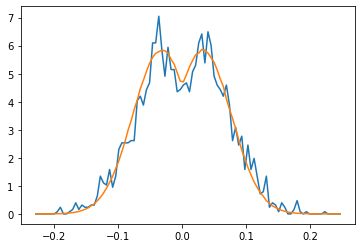

In [85]:
bin_cents = 0.5 * (hist_new[1][1:] + hist_new[1][:-1])
plt.plot(bin_cents, hist_new[0])
plt.plot(bin_cents, hist_fit[0])

This looks reasonable.

Next, we can look at the covariance of this and compare to the original.

In [86]:
sim_cov = utils.temporal_covariance(df_sim, max_sep=int(block_length/time_step), step=1)

  0%|          | 0/60 [00:00<?, ?it/s]

Text(0, 0.5, 'Covariance')

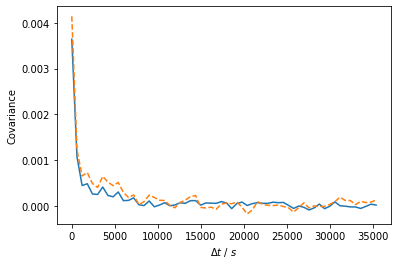

In [87]:
plt.plot(real_space_cov.keys(), real_space_cov.values())
plt.plot(sample_cov_points, sim_cov.values(), '--')
plt.xlabel("$\Delta t$ / $s$")
plt.ylabel("Covariance")

In [88]:
samples = utils.simulate_grf_using_cov(real_space_cov, max_time=block_length, time_step=time_step, num_samples=num_samples)

In [89]:
new_samples = [s.flatten()[:int(np.ceil(len(freq_table)/time_step))] for s in samples]

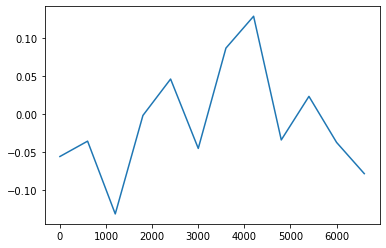

In [90]:
plt.plot(np.arange(int(7200/time_step))*time_step, new_samples[0][:int(7200/time_step)])

In [91]:
new_reals = {}

count = 0

for s in tqdm(new_samples):
    
    df = pd.DataFrame()
    df["date"] = np.arange(len(s)) * time_step
    df["delta_freq"] = s
    
    df_sim = df.copy()

    randoms = np.random.binomial(1, list(np.exp(-650*np.abs(df_sim.delta_freq)**2.0)))

    df_sim.delta_freq = np.where(
        randoms==1, df_sim.delta_freq*1.35
        , df_sim.delta_freq
    )
    
    df_sim = utils.add_charge_info(df_sim, service_power, delta_time=time_step)
    
    new_reals[count] = df_sim
    
    count+=1

  0%|          | 0/100 [00:00<?, ?it/s]

In [92]:
df_mean_new = new_reals[0].copy()
df_mean_new['culm_charge'] = 0.0
df_mean_new['culm_charge_sq'] = 0.0

for s in new_reals:
    
    df_mean_new['culm_charge'] += new_reals[s]['culm_charge']
    df_mean_new['culm_charge_sq'] += new_reals[s]['culm_charge']**2.0

In [93]:
df_mean_new['culm_charge'] = df_mean_new['culm_charge'] / len(new_reals)

In [94]:
df_mean_new['var_charge'] = (
    df_mean_new['culm_charge_sq'] / (len(new_reals) - 1)
    - df_mean_new['culm_charge']**2.0 * len(new_reals) / (len(new_reals) - 1)
)

In [95]:
df_mean_new['std_charge'] = np.sqrt(df_mean_new['var_charge'])

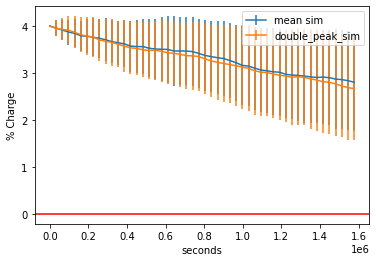

In [96]:
plt.errorbar(
    df_mean.iloc[sample_points_down].date,
    max_cap + df_mean.iloc[sample_points_down].culm_charge,
    df_mean.iloc[sample_points_down].std_charge,
    label="mean sim"
)
plt.errorbar(
    df_mean_new.iloc[sample_points_down].date,
    max_cap + df_mean_new.iloc[sample_points_down].culm_charge,
    df_mean_new.iloc[sample_points_down].std_charge,
    label='double_peak_sim'
)
plt.axhline(0.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

There doens't seem to be a big affect from the double peak, so in the analysis I will use the Gaussian assumption with the simulations to analyse the uncertainites. One last check I will do is compare the uncut data results with the original simulations to make sure there are no big differences.

In [97]:
samples = utils.simulate_grf_using_cov(real_space_cov_uncut, max_time=block_length, time_step=time_step, num_samples=num_samples)

In [98]:
new_samples = [s.flatten()[:int(np.ceil(len(freq_table)/time_step))] for s in samples]

In [99]:
reals = {}

count = 0

for s in tqdm(new_samples):
    
    df = pd.DataFrame()
    df["date"] = np.arange(len(s)) * time_step
    df["delta_freq"] = s
    df = utils.add_charge_info(df, service_power, delta_time=time_step)
    
    reals[count] = df
    
    count+=1

  0%|          | 0/100 [00:00<?, ?it/s]

In [100]:
df_mean_uncut = reals[0].copy()
df_mean_uncut['culm_charge'] = 0.0
df_mean_uncut['culm_charge_sq'] = 0.0

for s in reals:
    
    df_mean_uncut['culm_charge'] += reals[s]['culm_charge']
    df_mean_uncut['culm_charge_sq'] += reals[s]['culm_charge']**2.0

In [101]:
df_mean_uncut['culm_charge'] = df_mean_uncut['culm_charge'] / len(reals)

In [102]:
df_mean_uncut['var_charge'] = (
    df_mean_uncut['culm_charge_sq'] / (len(reals) - 1)
    - df_mean_uncut['culm_charge']**2.0 * len(reals) / (len(reals) - 1)
)

In [103]:
df_mean_uncut['std_charge'] = np.sqrt(df_mean_uncut['var_charge'])

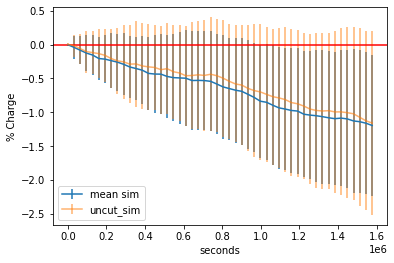

In [104]:
plt.errorbar(
    df_mean.iloc[sample_points_down].date,
    df_mean.iloc[sample_points_down].culm_charge,
    df_mean.iloc[sample_points_down].std_charge,
    label="mean sim"
)
plt.errorbar(
    df_mean_uncut.iloc[sample_points_down].date,
    df_mean_uncut.iloc[sample_points_down].culm_charge,
    df_mean_uncut.iloc[sample_points_down].std_charge,
    label='uncut_sim',
    alpha=0.6
)
plt.axhline(0.0, color='red')
plt.ylabel("% Charge")
plt.xlabel("seconds")
plt.legend()

There may be a slightly bigger error on the uncut simulation. We will use the uncut data in the main analysis.

The main part follows in the `Analysing the models` notebook